# Example 8: RVT SRA with simulated profiles

Use RVT with simulated profiles to compute the surface response spectrum and surface spectral ratio.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Create a point source theory RVT motion

In [3]:
m = pysra.motion.SourceTheoryRvtMotion(6.0, 30, 'wna')
m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=200), 10, 400),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=200), 20, 600),
    pysra.site.Layer(
        pysra.site.SoilType('Rock', 24., None, 0.01), 0, 1200),
])

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.ToroVelocityVariation.generic_model(
    'USGS C')
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
])

## Perform the calculation

In [8]:
count = 30
for profile in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity,
        var_soiltypes=var_soiltypes
):
    calc(m, profile, profile.location('outcrop', index=-1))
    outputs(calc)

## Plot the outputs

Create a few plots of the output.

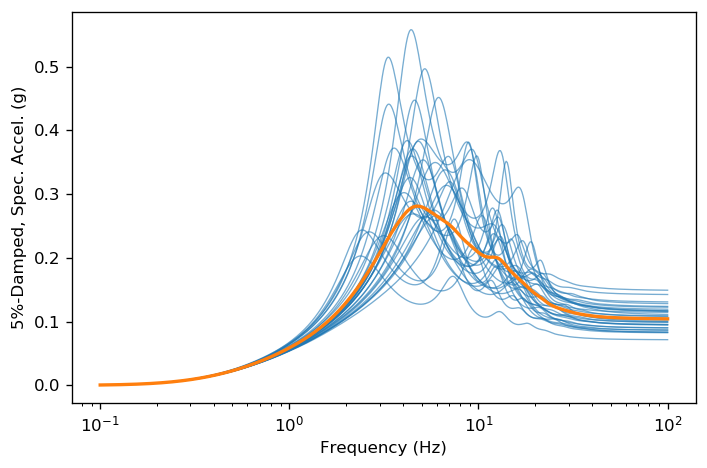

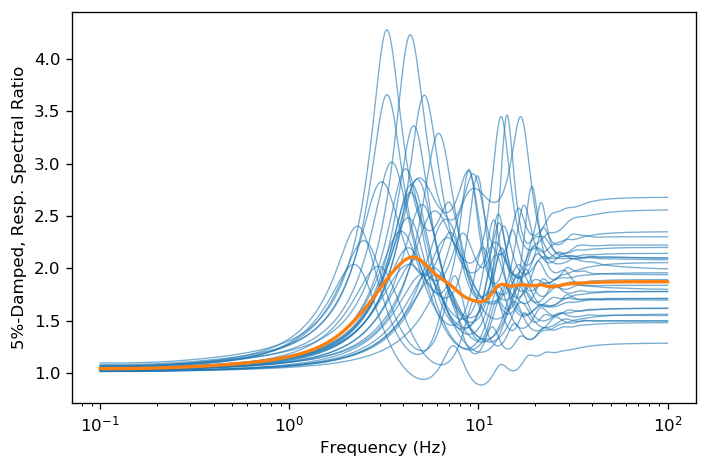

In [9]:
for o in outputs:
    fig, ax = plt.subplots()
    
    ax.plot(o.refs, o.values, color='C0', alpha=0.6, lw=0.8)
    ax.plot(o.refs, np.exp(np.mean(np.log(o.values), axis=1)), color='C1', lw=2)
    
    ax.set(xlabel=o.xlabel, xscale='log', ylabel=o.ylabel)
    fig.tight_layout();